# Reachable Surface Problem
This notebook provides an example of the reachable surface problem; we solve for the maximum area that the lander can safely reach on the surface without crashing or violating other operational constraints. This example is shown for Mars landing scenario with flat-planet assumption; constatnt gravity.


In [1]:
import numpy as np
import cvxpy as cp
from tqdm import tqdm
import sys
sys.path.append("../../")
import src.lcvx as lc
from src.visualization import *
%load_ext autoreload
%matplotlib inline

In [2]:
# Simulation configuration
rocket = lc.Rocket(
    g_=3.7114,
    mdry=1505.0,
    mwet=1905.0,
    Isp=225.0,
    rho1=4972.0,
    rho2=13260.0,
    gsa=25 * np.pi / 180,
    pa=30 * np.pi / 180,
    vmax=200.0,
)
N = 55
tf = 75.0
dt = tf / N
x0_bounds = (
    np.array([-100.0, 0.0, 1500.0, -50.0, 20.0, -75.0, np.log(rocket.mwet)]),  # Initial state vector (m, m, m, m/s, m/s, m/s, kg)
    np.array([0.0, 100.0, 1500.0, -50.0, 20.0, -75.0, np.log(rocket.mwet)]),  # Initial state vector (m, m, m, m/s, m/s, m/s, kg)
)

In [3]:
# Define the problem
lcvx = lc.LCvxReachability(rocket=rocket, N=N, maxk=N, 
directional_cstr=[True, True, False, False, False, False, False])
prob = lcvx.problem(x0_bounds=x0_bounds, tf=tf, xc=np.zeros(7))

In [4]:
# Define directional vectors
thetas = np.linspace(0, 2 * np.pi, 10)
x_profiles = []
u_profiles = []

for theta in tqdm(thetas):
    # Define directional vector
    c = np.array([np.cos(theta), np.sin(theta), 0.0, 0.0, 0.0, 0.0, 0.0])
    # Handle parameter; set the directional constraint
    lc.set_params(prob, {'c': c})
    # Solve the problem
    prob.solve(solver=cp.ECOS, verbose=False)
    # get solution
    sol = lc.get_vars(prob, ['X', 'U'])
    X_sol = sol['X']
    U_sol = sol['U']
    r, v, z, u, sigma = lcvx.recover_variables(X_sol, U_sol)
    m = np.exp(z)
    X = np.hstack((r.T, v.T, m.reshape(-1, 1)))
    U = u.T * m[:-1].reshape(-1, 1)
    # Store the profiles
    x_profiles.append(X)
    u_profiles.append(U)
t = np.linspace(0, tf, N + 1)

100%|██████████| 10/10 [00:00<00:00, 11.58it/s]


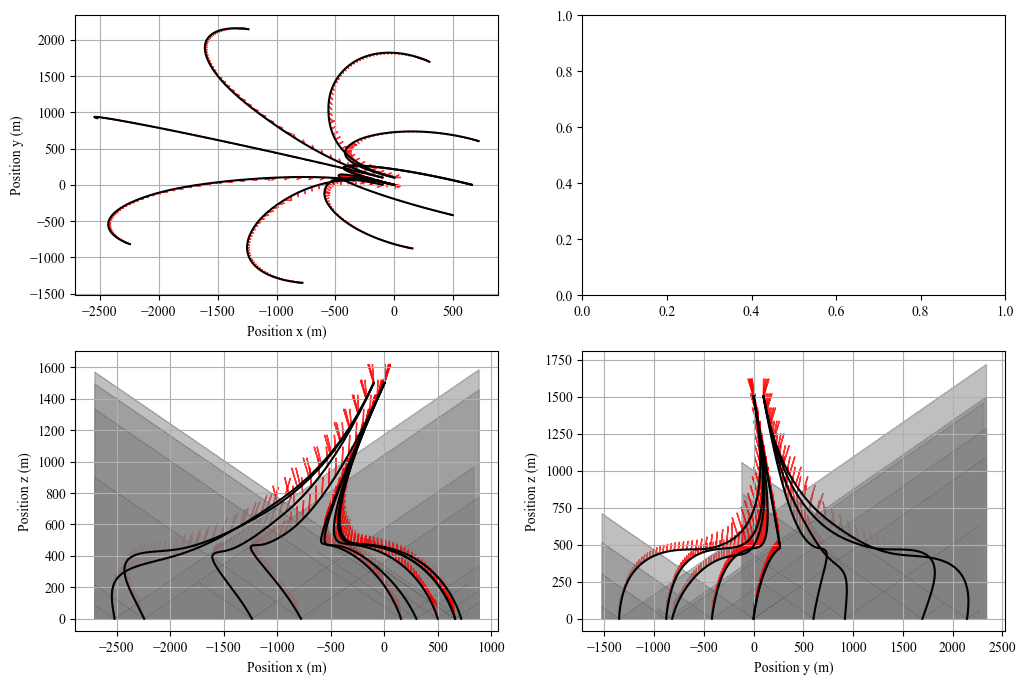

In [5]:
fig, axs = None, None
for i in range(len(thetas)):
    fig, axs = plot_3sides(t[:-1], x_profiles[i], u_profiles[i], uskip=1, gsa=rocket.gsa, fig=fig, axs=axs)

plt.show()